**Time Series Anlaysis - Project 1: SARIMA**

**Model Accuracy: 95.20% (non-rolling), 94.80% (rollling)** <br>
**In this project we will be predicting sales data using the SARIMA model** <br>
**The dataset can be found here: https://github.com/ritvikmath/Time-Series-Analysis/blob/master/catfish.csv**

***Importing Required Modules***

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from time import time
from pmdarima import auto_arima
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

***Formatting the dataset***

In [227]:
df = pd.read_csv("/Users/willbarnard/Downloads/catfish.csv", parse_dates=[0], index_col=[0], date_format = '%Y-%m-%d')
df = df.asfreq(pd.infer_freq(df.index))

start_date = datetime(1986, 1, 1)
end_date = datetime(2004, 1, 1)
lim_df = df[start_date:end_date]

***Splitting the dataset into training and testing***

In [228]:
X = lim_df.drop(columns=["Total"])
y = lim_df["Total"]

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training size: {len(X_train)}, Testing size: {len(X_test)}")

Training size: 173, Testing size: 44


***Displaying the dataset***

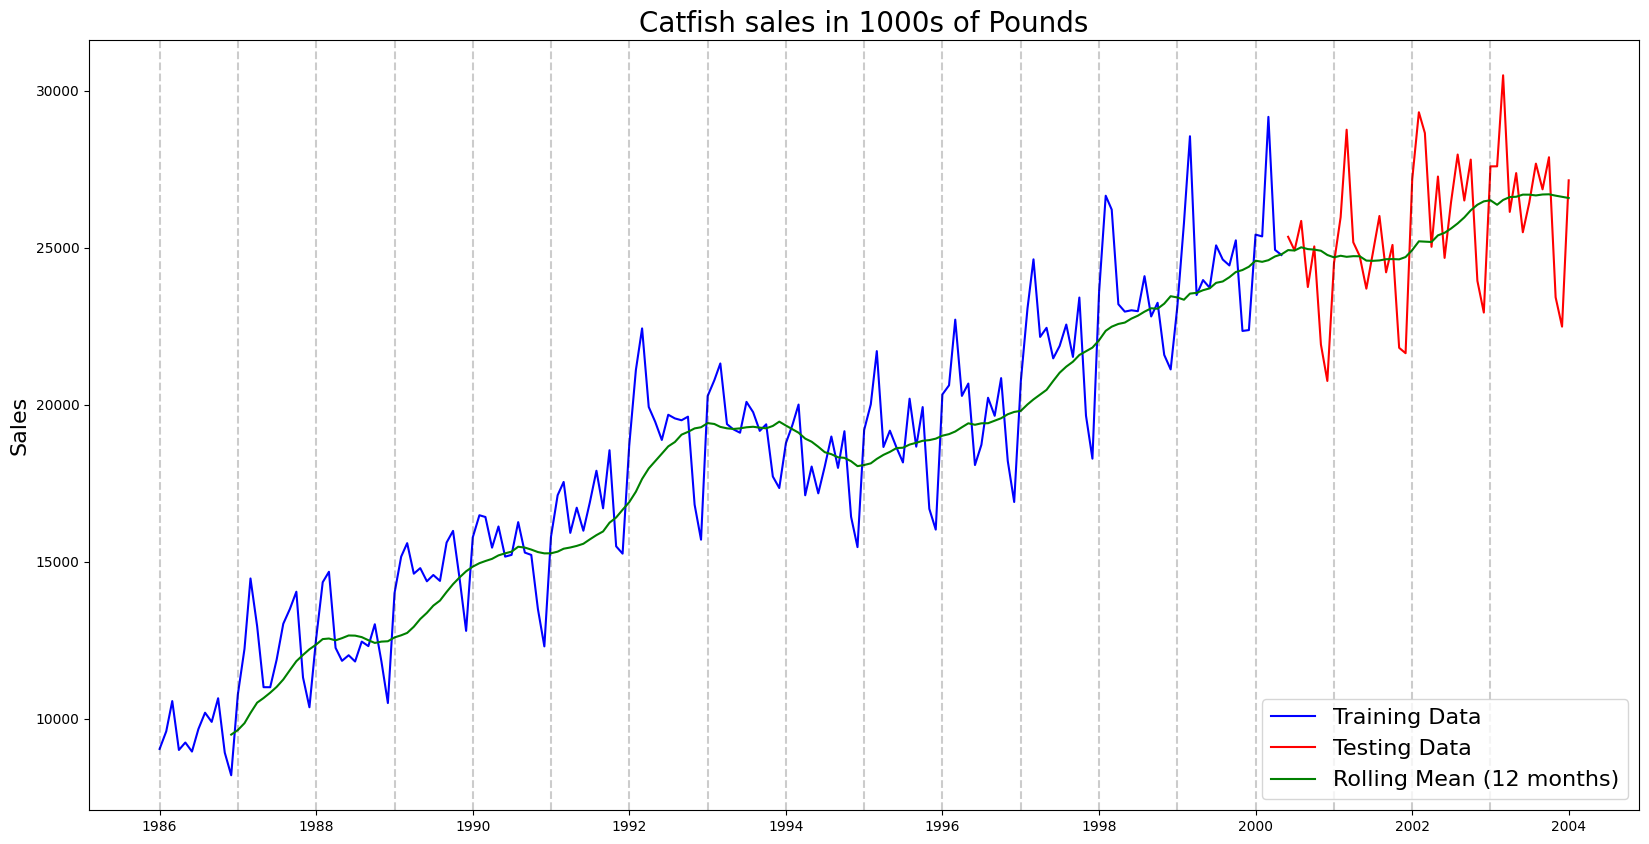

In [229]:
plt.figure(figsize=(20,10))
plt.plot(y_train,color='blue')
plt.plot(y_test,color='red')
plt.plot(lim_df.rolling(12).mean(), color='green')
plt.title('Catfish sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend(("Training Data", "Testing Data", "Rolling Mean (12 months)"), fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

**Seasonal decomposition of the dataset**

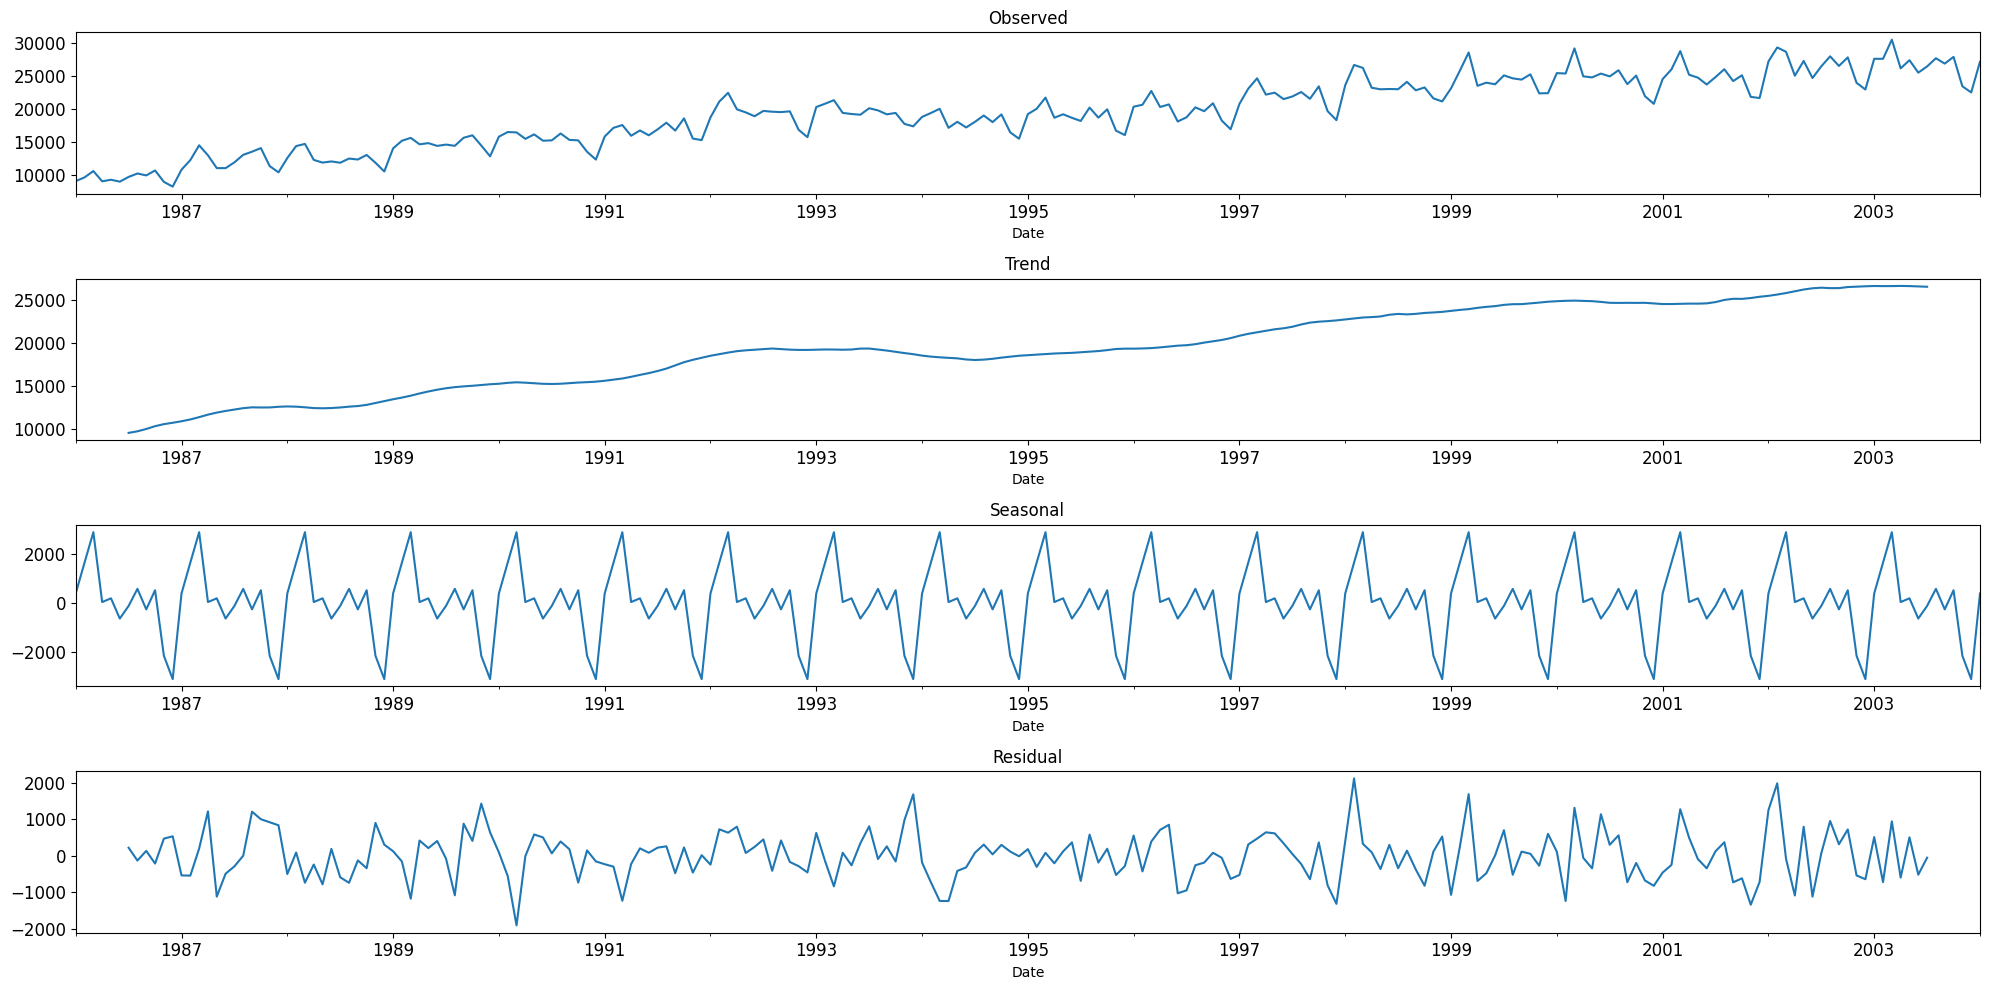

In [230]:
seasonal_decomp = sm.tsa.seasonal_decompose(lim_df, period=12)

fig, axes = plt.subplots(4, 1, figsize=(20, 10))  

seasonal_decomp.observed.plot(ax=axes[0], title="Observed", fontsize=12)
seasonal_decomp.trend.plot(ax=axes[1], title="Trend", fontsize=12)
seasonal_decomp.seasonal.plot(ax=axes[2], title="Seasonal", fontsize=12)
seasonal_decomp.resid.plot(ax=axes[3], title="Residual", fontsize=12)

plt.tight_layout()  
plt.show()

**ADF (Augmeneted Dickey-Fuller) test to check for stationary data**

In [231]:
result = adfuller(lim_df)

ADFtestStatistic = result[0]
pValue = result[1]
numLags = result[2]
numObservations = result[3]
criticalValues = result[4]

print("ADF Statistic: ", ADFtestStatistic)
print("p-value: ", pValue)
print("Number of lags: ", numLags)
print("Number of observations: ", numObservations)
print("Critical values: ", criticalValues)

if pValue <= 0.05:
    print("The series is likely stationary (reject null hypothesis). ")
else:
    print("The series is likely non-stationary (fail to reject null hypothesis).")

ADF Statistic:  -1.1673894339131337
p-value:  0.6874643453710805
Number of lags:  14
Number of observations:  202
Critical values:  {'1%': -3.4631437906252636, '5%': -2.8759570379821047, '10%': -2.574454682874228}
The series is likely non-stationary (fail to reject null hypothesis).


***Removing the trend through differencing***

In [232]:
first_diff = lim_df.diff()[1:]

***Displaying the differenced data***

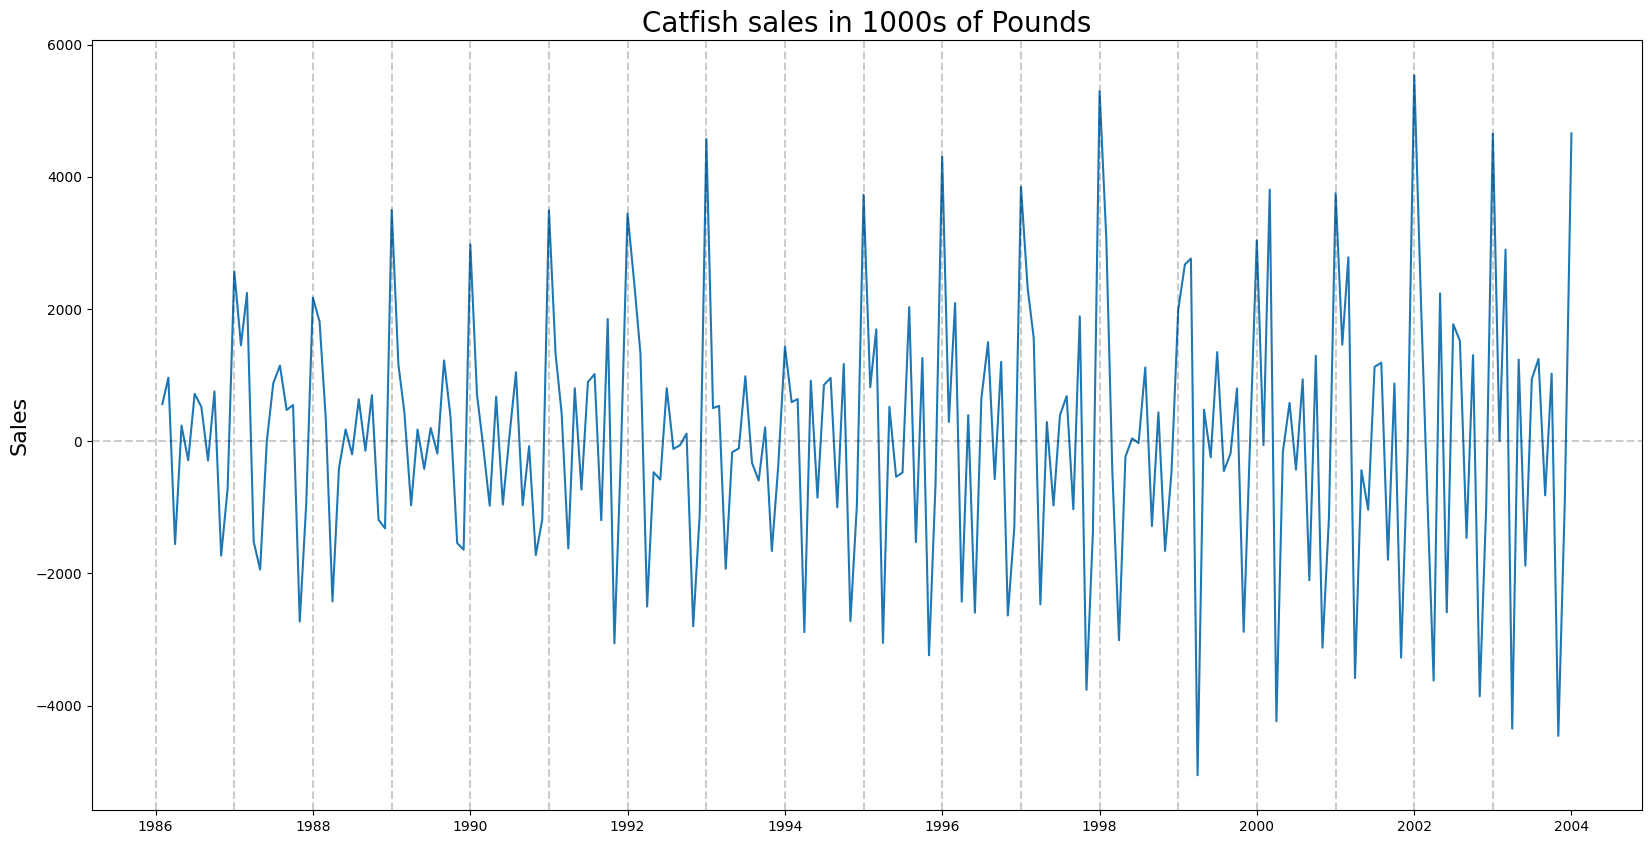

In [233]:
plt.figure(figsize=(20,10))
plt.plot(first_diff)
plt.title('Catfish sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)


***Calculating and displaying ACF (autocorrelation function)***

<BarContainer object of 17 artists>

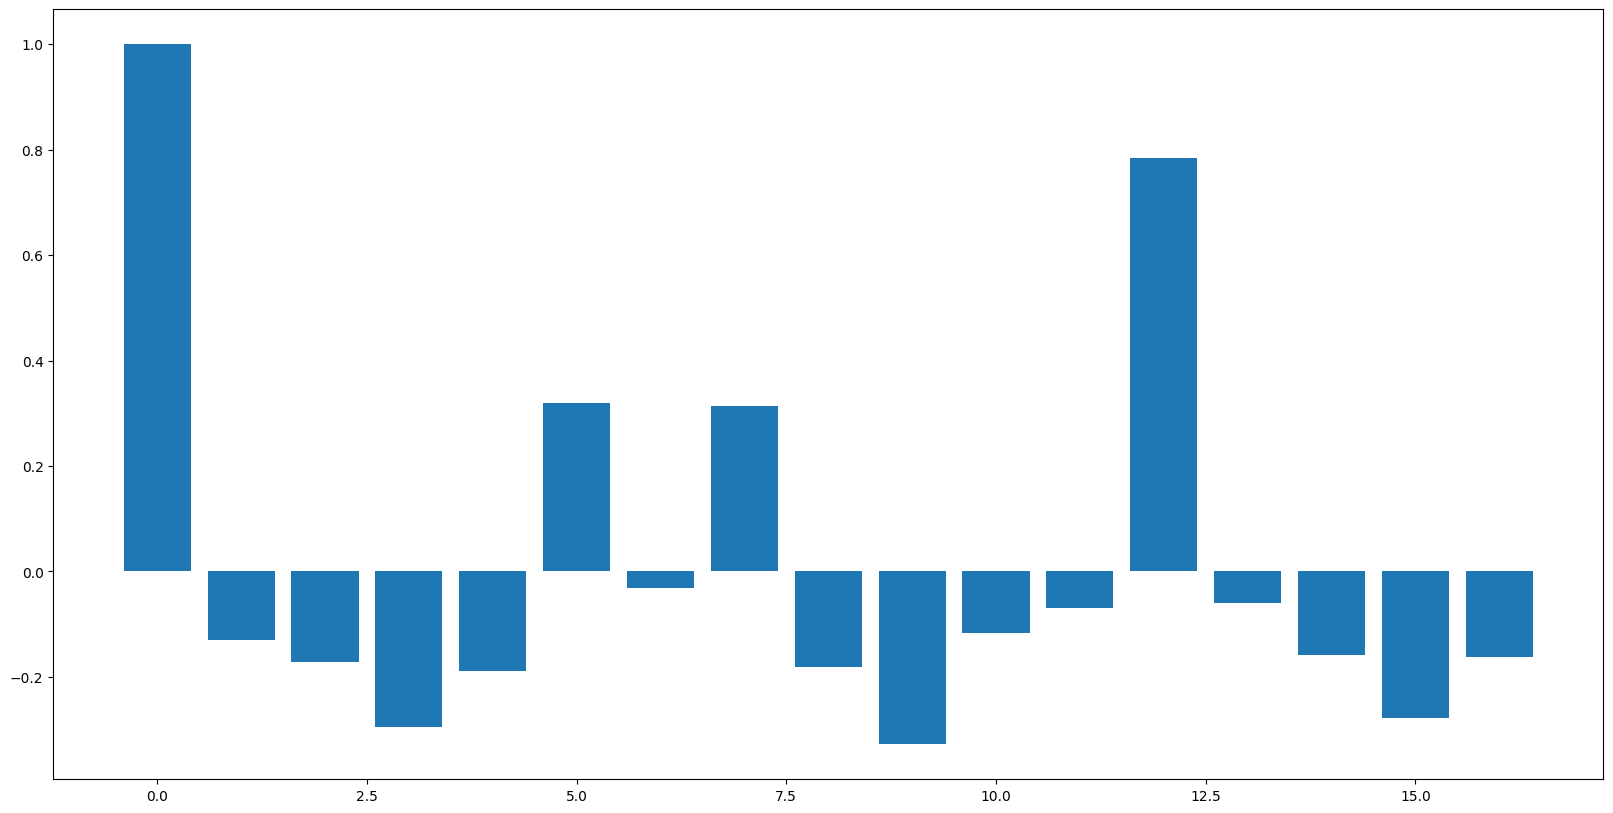

In [234]:
acf_vals = acf(first_diff)
plt.figure(figsize=(20,10))
num_lags = 17
plt.bar(range(num_lags), acf_vals[:num_lags])

***Calculating and displaying PACF (Partial Autocorrelation Function)***

<BarContainer object of 17 artists>

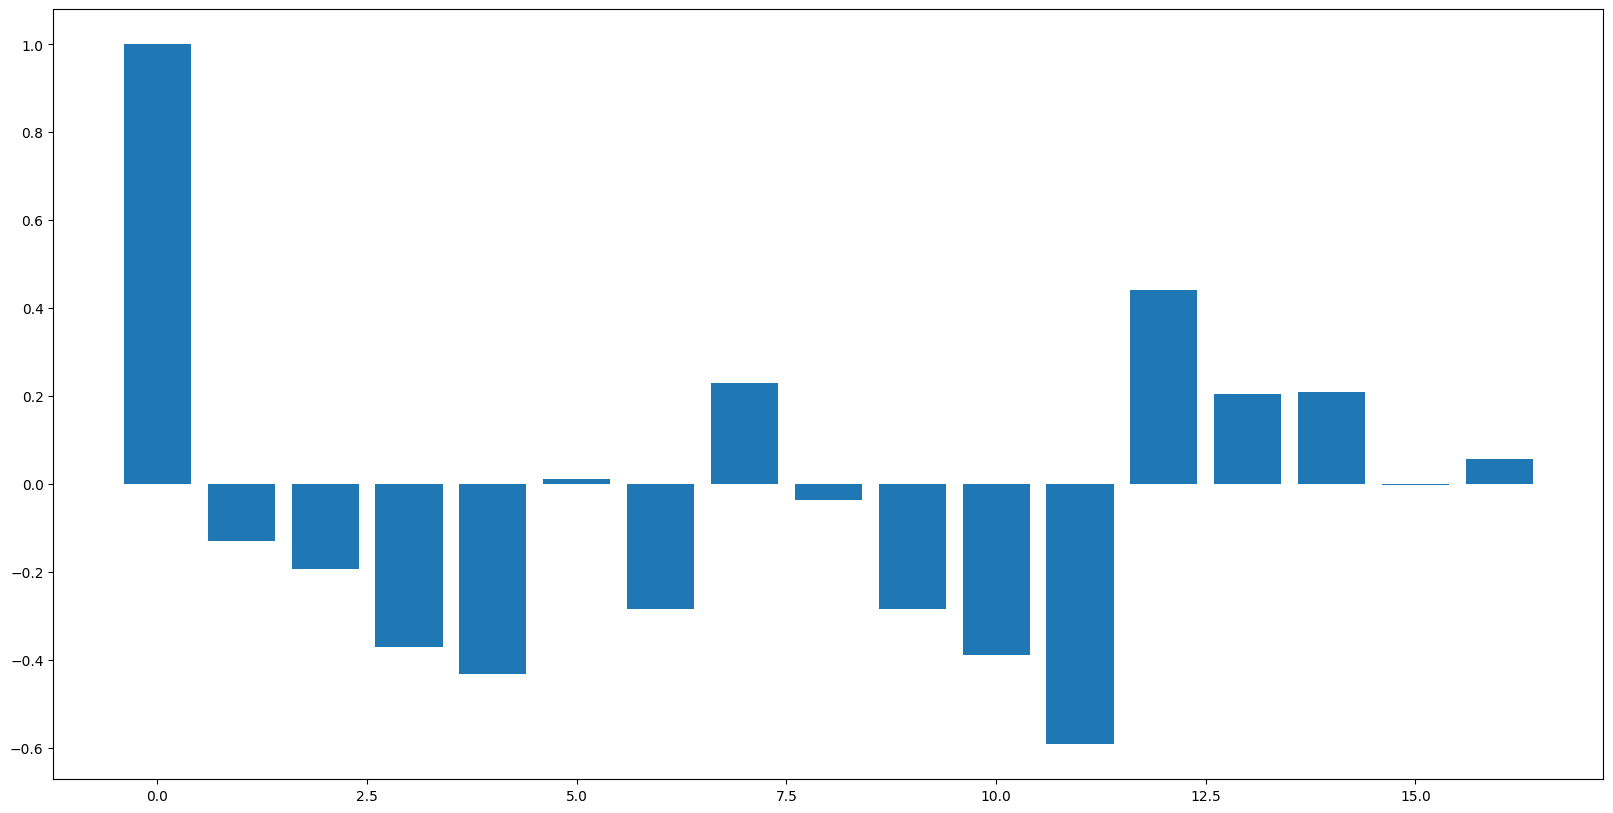

In [235]:
pacf_vals = pacf(first_diff)
plt.figure(figsize=(20,10))
num_lags=17
plt.bar(range(num_lags), pacf_vals[:num_lags])

***Recalculating ADF to ensure stationary data***

In [236]:
result = adfuller(first_diff)

ADFtestStatistic = result[0]
pValue = result[1]
numLags = result[2]
numObservations = result[3]
criticalValues = result[4]

print("ADF Statistic: ", ADFtestStatistic)
print("p-value: ", pValue)
print("Number of lags: ", numLags)
print("Number of observations: ", numObservations)
print("Critical values: ", criticalValues)

if pValue <= 0.05:
    print("The series is likely stationary (reject null hypothesis). ")
else:
    print("The series is likely non-stationary (fail to reject null hypothesis).")

ADF Statistic:  -3.577397927085576
p-value:  0.006208126413506886
Number of lags:  13
Number of observations:  202
Critical values:  {'1%': -3.4631437906252636, '5%': -2.8759570379821047, '10%': -2.574454682874228}
The series is likely stationary (reject null hypothesis). 


***Parameter selection: graphical observations***

In [237]:
my_order = (0, 1, 0)
my_seasonal_order = (1, 0, 1, 12)

***Parameter selection: AutoArima search***

In [238]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [239]:
auto_model = auto_arima(y_train, seasonal=True, m=12, stepwise=True, trace=True)
auto_model.summary()
p, d, q = auto_model.order
P, D, Q, s = auto_model.seasonal_order
print(p, d, q, P, D, Q, s)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3057.857, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2870.822, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2953.885, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3056.337, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3058.809, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2830.838, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2958.248, Time=0.07 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2871.522, Time=0.73 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2925.320, Time=0.32 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2857.178, Time=0.26 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : 

***Define the SARIMA Model***

In [240]:
model = SARIMAX(y_train, order=(0,1,1), seasonal_order=(1, 0, 1, 12))

***Fit the Model***

In [241]:
start = time()
model_fit = model.fit(disp=0)
end = time()
print('Model Fitting Time: ', end - start)
model_fit.summary()

Model Fitting Time:  0.11450505256652832


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Total   No. Observations:                  173
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1404.787
Date:                            Thu, 05 Jun 2025   AIC                           2817.575
Time:                                    15:10:13   BIC                           2830.164
Sample:                                01-01-1986   HQIC                          2822.683
                                     - 05-01-2000                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4612      0.060     -7.686      0.000      -0.579      -0.344
ar.S.L12       0.9894      0.009    107.618      0.000       0.971       1.007
ma.S.L12      -0.7862      0.080     -9.854      0.000      -0.943      -0.630
sigma2      6.239e+05   6.86e+04      9.091      0.000    4.89e+05    7.58e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 2.73
Prob(Q):                              0.63   Prob(JB):                         0.26
Heteroskedasticity (H):               1.71   Skew:                             0.29
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

***Calculate predictions***

In [242]:
predictions = model_fit.forecast(len(y_test))
predictions = pd.Series(predictions, index=y_test.index)



**Calculating residuals**

In [243]:
residuals = y_test - predictions

***Displaying residuals***

Text(0, 0.5, 'Error')

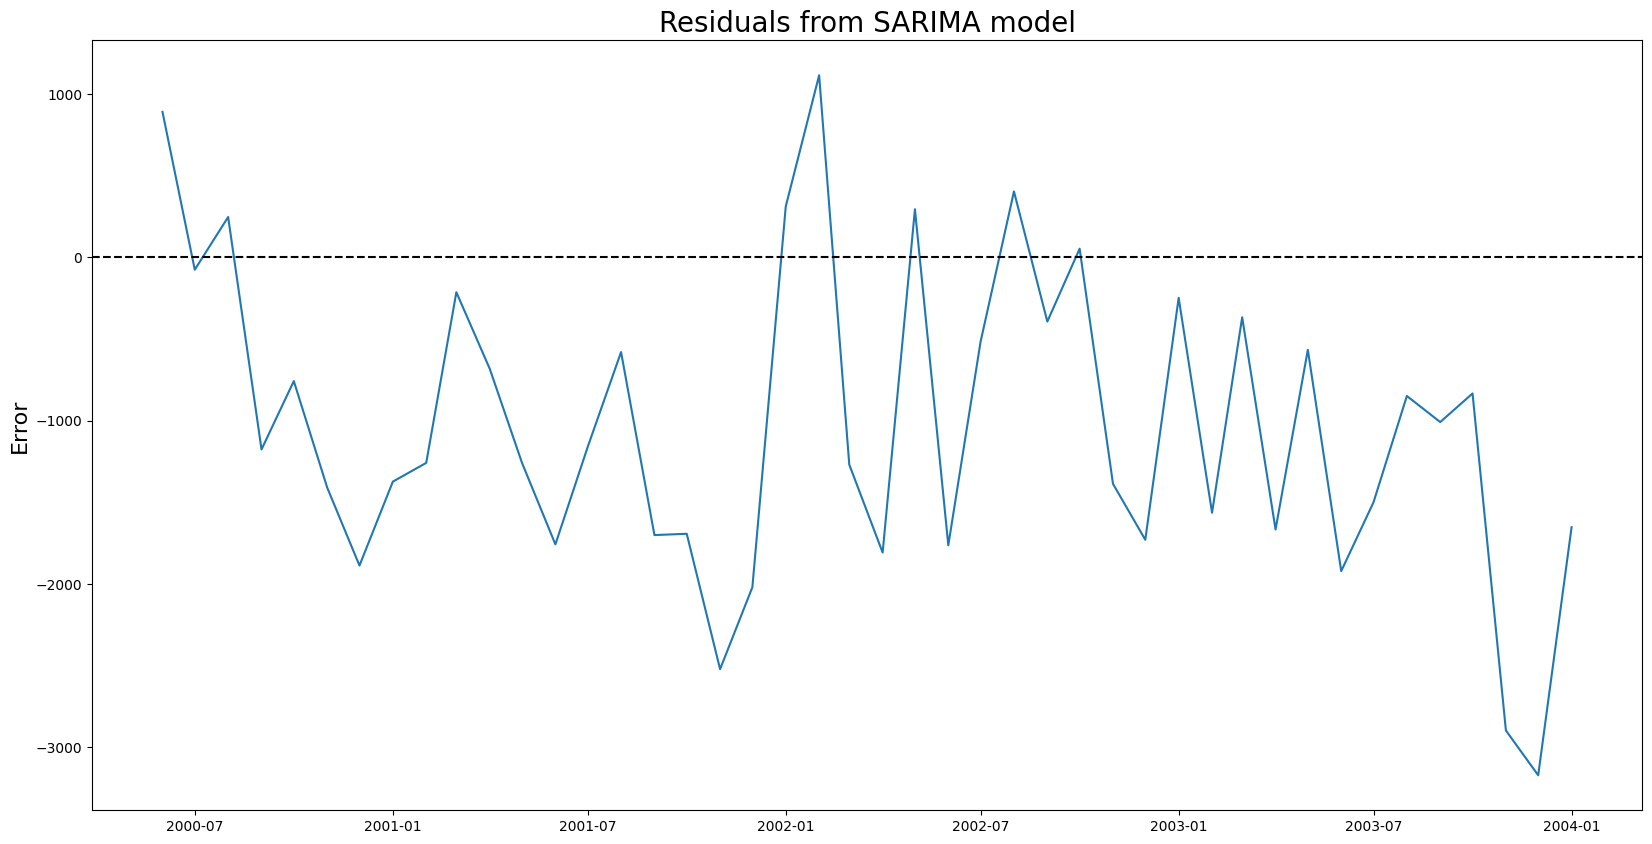

In [244]:
plt.figure(figsize=(20,10))
plt.plot(residuals)
plt.axhline(0, linestyle = '--', color='k')
plt.title('Residuals from SARIMA model', fontsize=20)
plt.ylabel('Error', fontsize=16)

***Displaying the model's predictions***

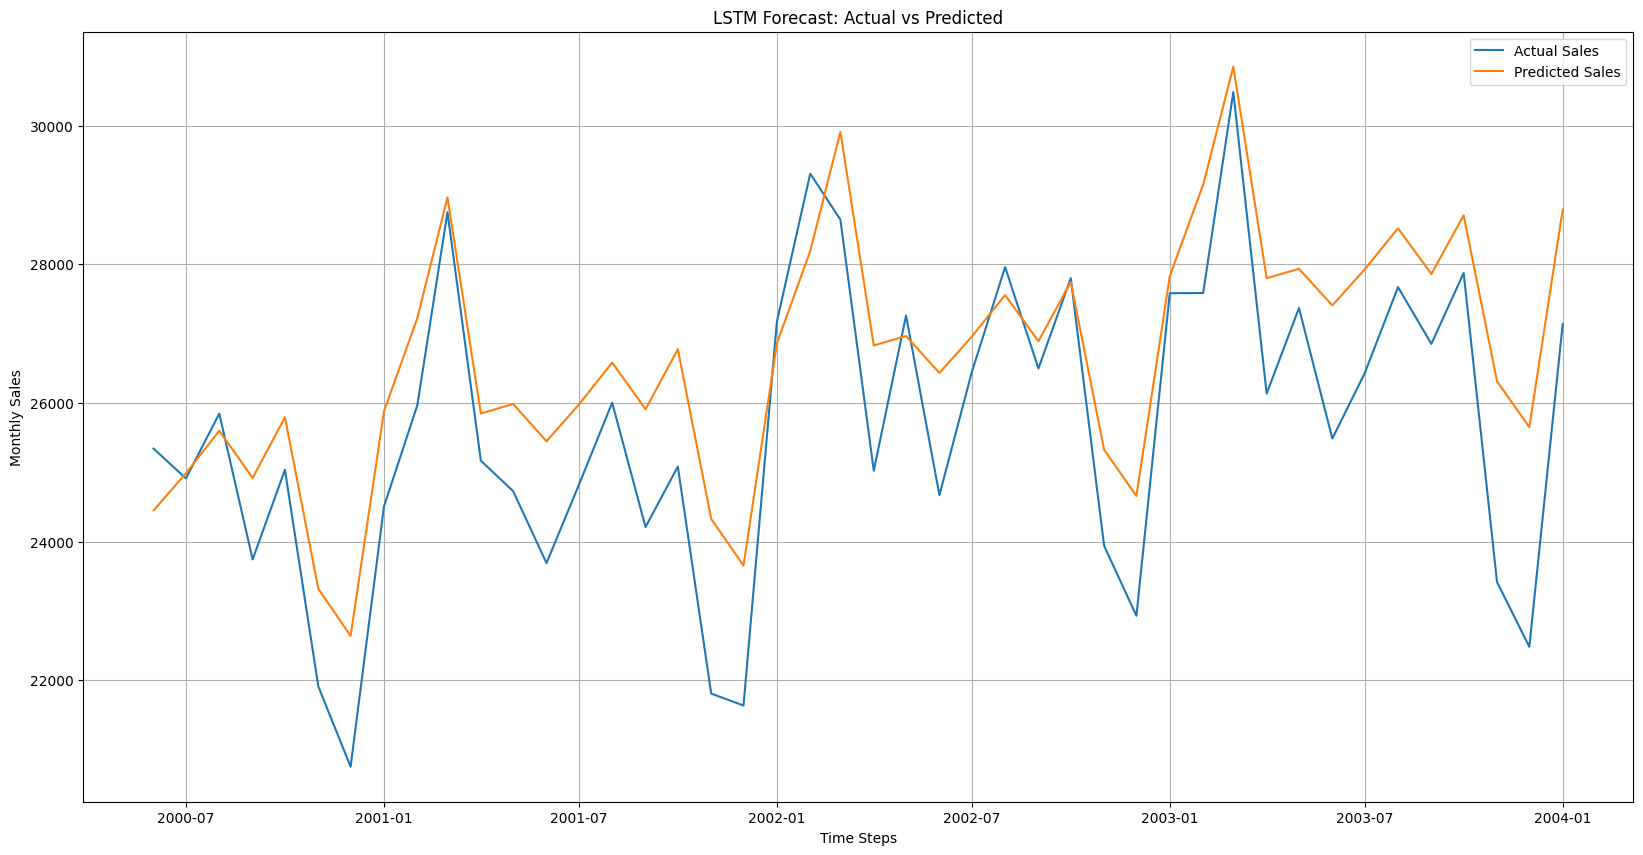

In [245]:
plt.figure(figsize=(20, 10))
plt.plot(y_test, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales')
plt.title("LSTM Forecast: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Monthly Sales")
plt.legend()
plt.grid(True)
plt.show()

***Displaying predictions for the entire dataset***

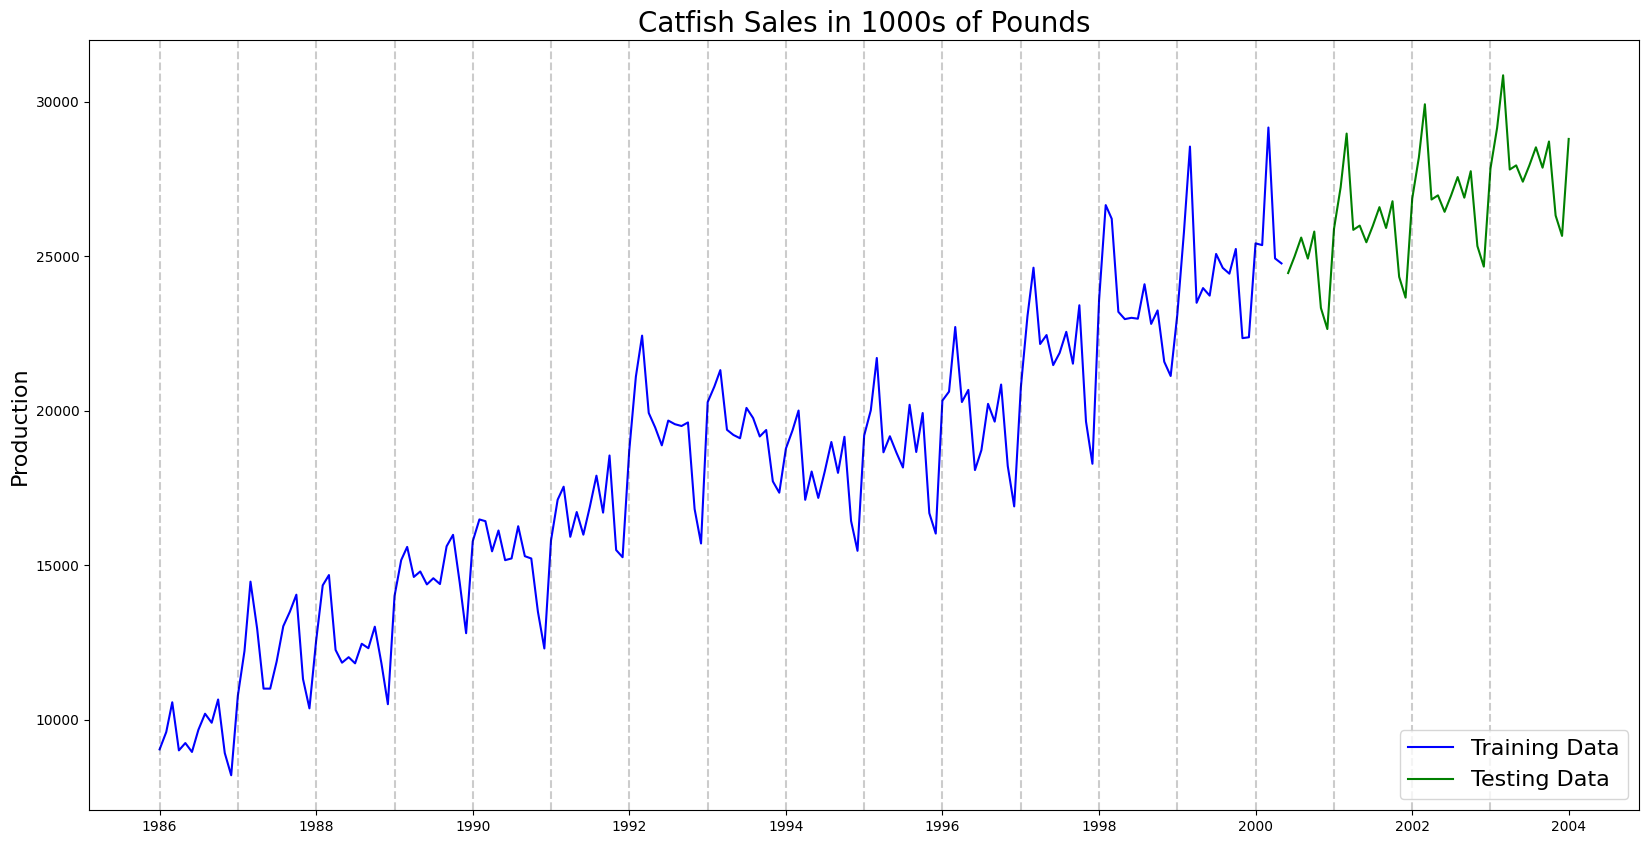

In [246]:
plt.figure(figsize=(20,10))

plt.plot(y_train,color='blue')
plt.plot(predictions, color='green')

plt.legend(('Training Data', 'Testing Data', 'Predictons'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)

***Error metric: MAPE***

In [247]:
print('Mean Absolute Percent error: ', round(np.mean(abs(residuals/y_test)), 4))

Mean Absolute Percent error:  0.048


***Error metric: RMSE***

In [248]:
print('Root Mean Squarred Error: ', np.sqrt(np.mean(residuals**2)))

Root Mean Squarred Error:  1390.1453803519585


***Calculating rolling forecasts***

In [249]:
rolling_predictions = y_test.copy()

train_end = y_train.index[-1]

history = lim_df[:train_end].copy()

for current_date in y_test.index:
    model = SARIMAX(history['Total'], order=(0,1,1), seasonal_order=(1,1,0,12))
    model_fit = model.fit(disp=0)
    
    pred = model_fit.forecast()
    rolling_predictions[current_date] = float(pred.iloc[0])
    

    history.loc[current_date] = [pred.iloc[0]] + [np.nan]*(history.shape[1]-1) 


***Calcuating Rolling residuals***

In [250]:
rolling_residuals = y_test - rolling_predictions

***Displaying rolling residuals***

Text(0, 0.5, 'Error')

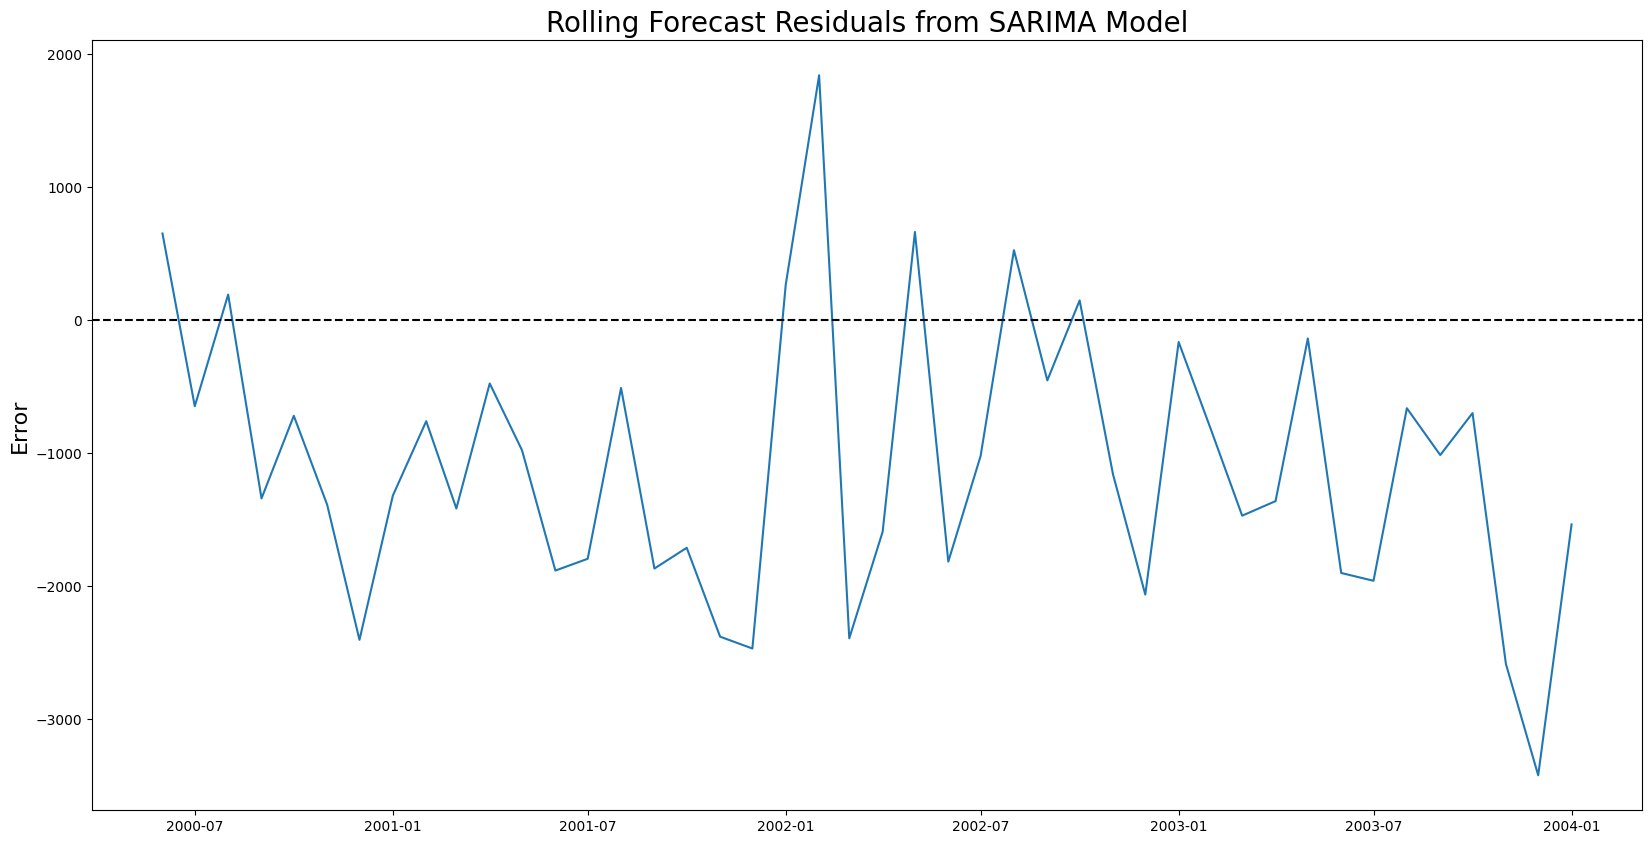

In [251]:
plt.figure(figsize=(20,10))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

***Displaying the model's rolling predictions***

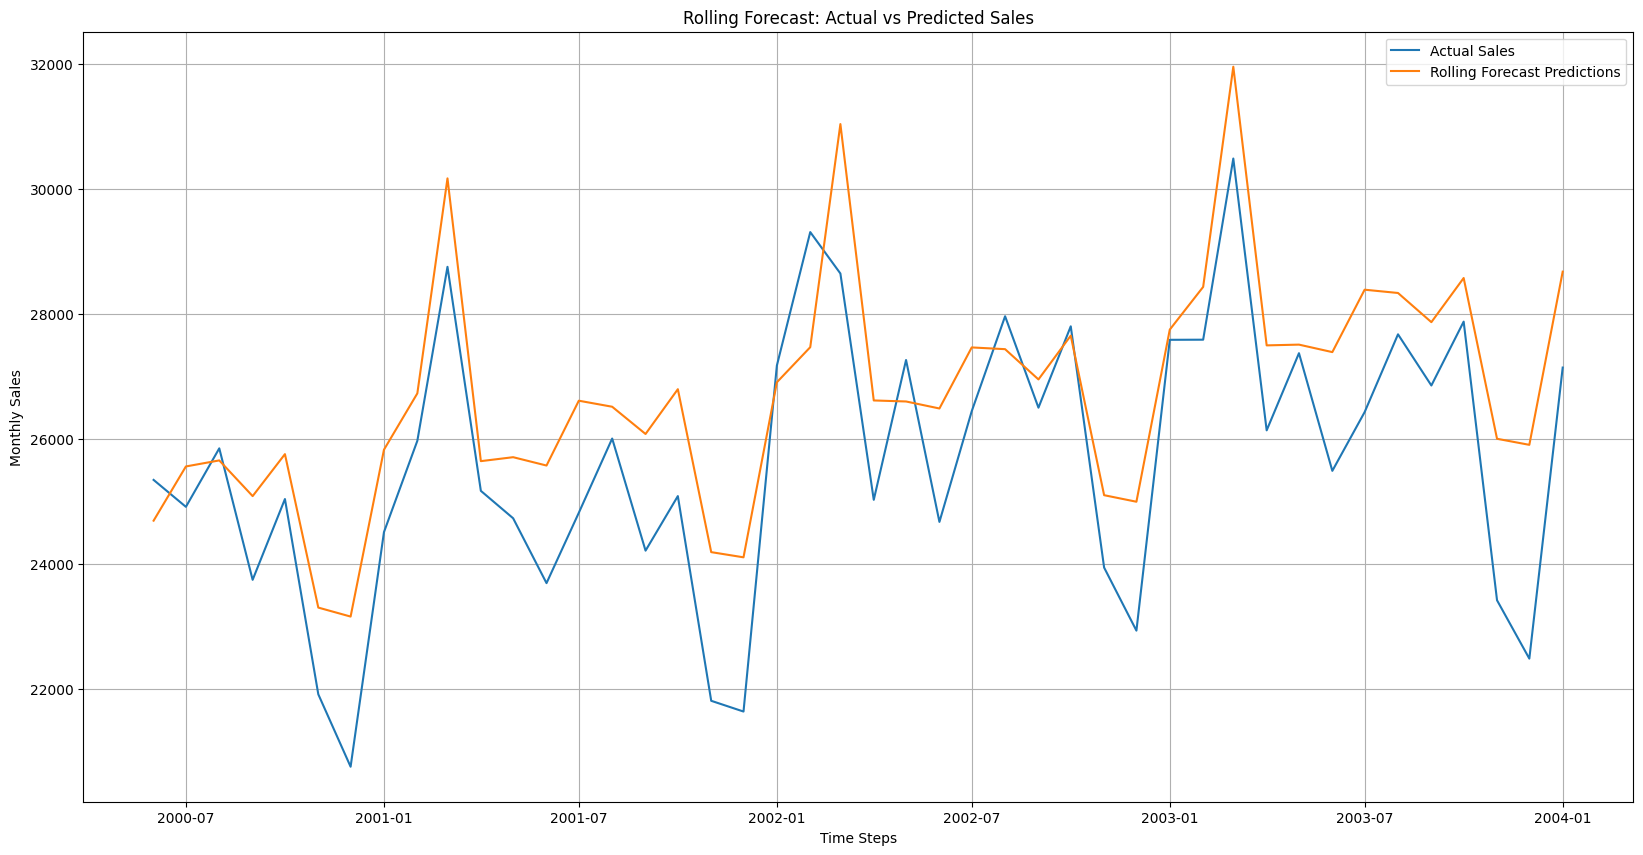

In [252]:
plt.figure(figsize=(20, 10))
plt.plot(y_test, label='Actual Sales')
plt.plot(rolling_predictions, label='Rolling Forecast Predictions')
plt.title("Rolling Forecast: Actual vs Predicted Sales")
plt.xlabel("Time Steps")
plt.ylabel("Monthly Sales")
plt.legend()
plt.grid(True)
plt.show()

***Displaying rolling predictions against the entire dataset***

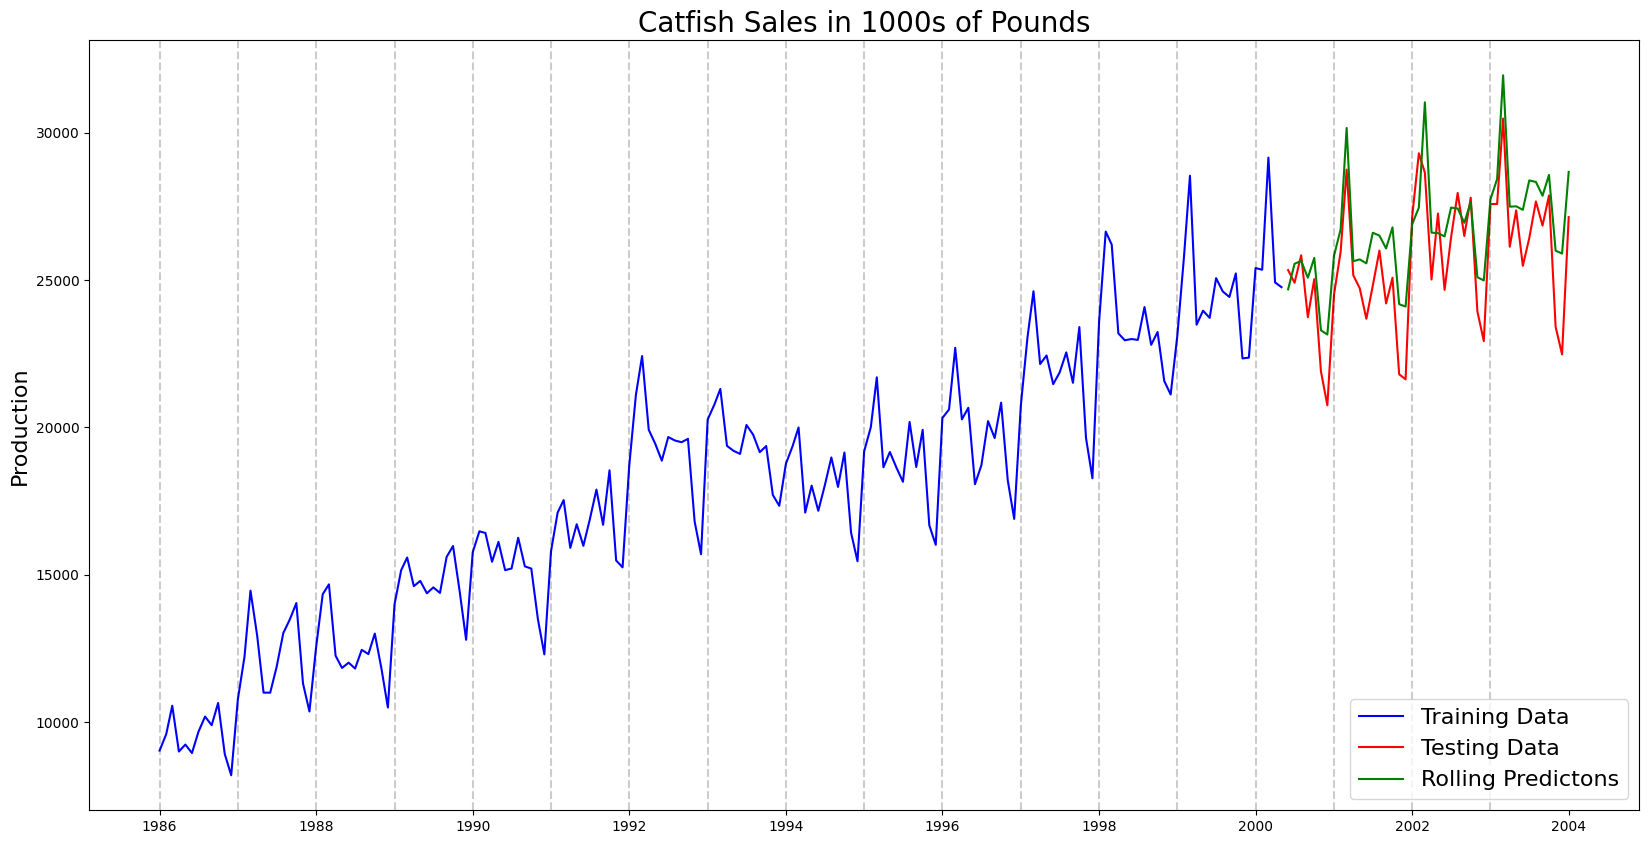

In [253]:
plt.figure(figsize=(20,10))
plt.plot(y_train,color='blue')
plt.plot(y_test,color='red')
plt.plot(rolling_predictions, color='green')

plt.legend(('Training Data', 'Testing Data', 'Rolling Predictons'), fontsize=16)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year) +  '-01-01'), color='k', linestyle='--', alpha=0.2)

***Error metric: MAPE***

In [254]:
print('Mean Absolute Percent Error: ', round(np.mean(abs(rolling_residuals/y_test)), 4))

Mean Absolute Percent Error:  0.052


***Error metric: RMSE***

In [255]:
print('Root Mean Squared Error: ', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error:  1500.5456751419267
